## MLMA Retinal Vein Puncture Detection Notebook
This notebook has the code to load in a YOLO V11 segmentation model, run inference, and identify if the vein has been punctured given a set of images.
Written by Aabhas Jain

In [1]:
!pip install ultralytics
from ultralytics import YOLO
import cv2
import os
import numpy as np
import math
import timeit
import torch
import csv
import time
import pandas as pd
import math
from IPython.display import Image, display
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
!pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp
from torchvision import transforms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.0 MB/s eta 0:00:00


In [3]:
%matplotlib inline

In [4]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("PyTorch CUDA version:", torch.version.cuda)

CUDA available: True
PyTorch CUDA version: 12.4


# Helper Functions

In [5]:
def get_image_paths(starting_image_path, num_images):
    """
    Returns a list of the image paths (alphabetically) in the folder including and after the starting image.

    Parameters:
        starting_image_path (str): The full path of the starting image.
        num_images (int): The number of subsequent image paths to retrieve.

    Returns:
        List[str]: A list of image paths following the starting image.
    """
    # Get the folder containing the starting image
    folder = os.path.dirname(starting_image_path)

    # Define valid image extensions
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}

    # List all image files in the folder with valid extensions
    all_images = [
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if os.path.splitext(f)[1].lower() in valid_extensions
    ]

    # Sort images alphabetically
    all_images.sort()

    # Try to find the starting image in the sorted list
    try:
        start_index = all_images.index(starting_image_path)
    except ValueError:
        raise ValueError(f"Starting image not found in folder: {starting_image_path}")

    # Get the next num_images images (if available)
    images = all_images[start_index: start_index + num_images]
    return images

In [6]:
def show_image(img, title="Image"):
    %matplotlib inline
    print("[DEBUG] show_image called")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [7]:
def detect_needle_and_edges(mask, img, canny_thresholds=(50, 100)):
        """
        Crops a region from the image using the given bounding box and applies edge detection.

        Parameters:
            mask (Image): Mask image (OpenCV format).
            canny_thresholds (tuple): (threshold1, threshold2) for Canny edge detection.

        Returns:
            cropped_img (np.ndarray): Cropped image region.
            edges (np.ndarray): Edge-detected version of the cropped image.
        """
        start = timeit.timeit()
        mask = mask.astype(np.uint8) * 255
        # show_image(mask)
        # cv2.waitKey(1)  # Use 1ms delay so window stays responsive

        edges = cv2.Canny(mask, *canny_thresholds)
        edge_lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=10)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            print("No contours found in mask.")
            return None, None

        # Use the largest contour (needle)
        contour = max(contours, key=cv2.contourArea)

        # Tip = lowest
        tip_point = min(contour, key=lambda pt: pt[0][1])
        cv2.circle(img, tip_point[0], 5, (255, 0, 0), -1)
        end = timeit.timeit()
        # print("Time: {:.5f} s".format(end - start))
        return edge_lines, tip_point[0]

In [8]:
def calc_needle_params(edge_lines, img):
    """
    Calculates needle average angle from horizontal based on Hough Transform and a bunch of other parameters.
    :param edge_lines: (np.ndarray) Output of cv2.HoughLinesP.
    :return:
        dict: needle data containing angle, center, length, and reconstructed endpoints.
    """
    # print("in calc_needle_params")
    if edge_lines is None:
        return None
    # print(edge_lines.shape)
    # print(edge_lines[:3])
    angles = []
    x_centers = []
    y_centers = []
    lengths = []
    for line in edge_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1, cv2.LINE_AA)

        angle_rad = math.atan2(y2 - y1, x2 - x1)
        angle_deg = math.degrees(angle_rad)
        angles.append(angle_deg)

        x_centers.append((x1 + x2) // 2)
        y_centers.append((y1 + y2) // 2)

        length = np.hypot(x2 - x1, y2 - y1)
        lengths.append(length)

    avg_angle_deg = np.mean(angles)
    avg_angle_rad = math.radians(avg_angle_deg)
    avg_length = np.mean(lengths)
    center_x = int(np.mean(x_centers))
    center_y = int(np.mean(y_centers))


    # Half line to add in each direction
    dx = int((avg_length / 2) * math.cos(avg_angle_rad))
    dy = int((avg_length / 2) * math.sin(avg_angle_rad))

    # Endpoints of the average line
    p1 = (center_x - dx, center_y - dy)
    p2 = (center_x + dx, center_y + dy)

    cv2.line(img, p1, p2, (0, 255, 0), 2, cv2.LINE_AA)
    needle_data = {
        "p1": p1,
        "p2": p2,
        "center": (center_x, center_y),
        "length": avg_length,
        "angle_deg": avg_angle_deg,
        "angle_rad": avg_angle_rad
    }
    return needle_data

In [9]:
def run_inference_yolo(image_path, verbose=False):
    # results = model(image_path, verbose=verbose, device=0)
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"cv2.imread failed for {image_path}")
    results = model(img, verbose=verbose, device=0)
    # show_image(img)

    if results is not None:
        for r in results:
            masks = r.masks
            boxes = r.boxes # I'm not using the boxes, but need them for classes

            if masks is not None and masks.data is not None and boxes is not None:
                classes = boxes.cls.cpu().numpy().astype(int)
                masks_data = masks.data.cpu().numpy()

                for i, class_id in enumerate(classes):
                    class_name = class_map[class_id]
                    mask = masks_data[i]
                    # print(f"Detected: {class_name} (class_id: {class_id})")
                    if class_name == "Needle":
                        edge_lines, needle_tip = detect_needle_and_edges(mask, img)
                        needle = calc_needle_params(edge_lines, img)
                        # if needle is None:
                        #     print(f"Needle params not found for {os.path.basename(image_path)}")
                        # else:
                        #     log_data = logger.compute(image_path, needle, r, needle_tip, img)
                            # print(f"[DEBUG] Logged data for {os.path.basename(image_path)}")
                        if needle is not None:
                            log_data = logger.compute(image_path, needle, r, needle_tip, img)
                            # print("Logged data")

                            # print(f"[{log_data['image_time']}] ∆t: {log_data['delta_t']:.3f}s ∆θ: {log_data['delta_angle']:.2f}° " f"→ θ: {log_data['angle_deg']:.2f}°, ω: {log_data['w']:.2f}°/s, inference: {log_data['inference_time_ms']:.2f}ms")
                            # cv2.imshow("Image", img)
                            # cv2.waitKey(0)
                            # cv2.destroyAllWindows()
                    elif class_name == "Vein":
                        print("Vein detected")
    else:
        print("No results")


# Data Logging Helper Functions

In [10]:
class NeedleLogger:
    def __init__(self, csv_path="needle_log.csv", overwrite=True):
        self.last_time = None
        self.last_angle = None
        self.last_tip = None
        self.last_image = None
        self.last_w = None
        self.last_v = None
        self.puncture_detected = False

        self.w_threshold = 30
        self.v_threshold = 17
        self.csv_path = csv_path

        self.frame_folder = os.path.join(os.path.dirname(self.csv_path), "video_frames")
        os.makedirs(self.frame_folder, exist_ok=True)
        self.frame_count = 0
        if overwrite and os.path.exists(self.csv_path):
            os.remove(self.csv_path)

        with open(self.csv_path, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                "image_time", "angle_deg", "inference_time_ms",
                "delta_t", "delta_angle", "w",
                "dx_dt", "dy_dt", "v", "alpha", "acceleration",
                "puncture_detected"
            ])

    def compute(self, image_path, needle_data, yolo_result, tip_xy, current_image):
        log_data = self.calculate(image_path, needle_data, yolo_result, tip_xy)
        self.detect_puncture(log_data, current_image)
        self.write_to_csv(log_data)
        self.update_last(log_data, tip_xy, current_image)
        self.save_annotated_frame(current_image, tip_xy, log_data["angle_deg"],
                          log_data["w"], log_data["v"], log_data["image_time"])

        return log_data

    def calculate(self, image_path, needle_data, yolo_result, tip_xy):
        image_filename = os.path.basename(image_path)
        image_time_str = image_filename.split("_")[-1].replace(".jpg", "")
        current_time = float(image_time_str)

        current_angle = needle_data["angle_deg"]
        dt = current_time - self.last_time if self.last_time is not None else 0.0
        dtheta = current_angle - self.last_angle if self.last_angle is not None else 0.0
        # w = dtheta / dt if dt > 0 else 0.0
        w = dtheta
        dx_dt = dy_dt = v = 0.0
        if self.last_tip is not None and dt > 0:
            dx = tip_xy[0] - self.last_tip[0]
            dy = tip_xy[1] - self.last_tip[1]
            # dx_dt = dx / dt
            # dy_dt = dy / dt
            dx_dt = dx
            dy_dt = dy
            v = math.sqrt(dx_dt**2 + dy_dt**2)

        alpha = a = 0.0

        if self.last_w is not None and dt > 0:
            alpha = (w - self.last_w) / dt
        if self.last_v is not None and dt > 0:
            a = (v - self.last_v) / dt

        inference_time_ms = yolo_result.speed['inference']

        return {
            "image_time": image_time_str,
            "angle_deg": current_angle,
            "inference_time_ms": inference_time_ms,
            "delta_t": dt,
            "delta_angle": dtheta,
            "w": w,
            "dx_dt": dx_dt,
            "dy_dt": dy_dt,
            "v": v,
            "alpha": alpha,
            "acceleration": a,
            "puncture_detected": self.puncture_detected
        }

    def detect_puncture(self, log_data, current_image):
        if self.puncture_detected:
            return

        w = log_data["w"]
        v = log_data["v"]

        if v > self.v_threshold:
            print(f"Puncture detected at {log_data['image_time']}: w={w:.2f}, v={v:.2f}")
            self.puncture_detected = True

            # Save side-by-side image
            pre_img = self.label_image(self.last_image, "Pre-Puncture") if self.last_image is not None else np.zeros_like(current_image)
            post_img = self.label_image(current_image, "Puncture Frame")
            combined = np.hstack((pre_img, post_img))
            cv2.imwrite("puncture_frame_comparison.png", combined)
            print("Puncture comparison saved to 'puncture_frame_comparison.png'")

        log_data["puncture_detected"] = self.puncture_detected

    def label_image(self, img, label):
        labeled = img.copy()
        cv2.putText(labeled, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2, cv2.LINE_AA)
        return labeled

    def write_to_csv(self, log_data):
        with open(self.csv_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                log_data["image_time"], log_data["angle_deg"],
                log_data["inference_time_ms"],
                log_data["delta_t"], log_data["delta_angle"], log_data["w"],
                log_data["dx_dt"], log_data["dy_dt"], log_data["v"],
                log_data["alpha"], log_data["acceleration"],
                log_data["puncture_detected"]
            ])

    def update_last(self, log_data, tip_xy, current_image):
        self.last_time = float(log_data["image_time"])
        self.last_angle = log_data["angle_deg"]
        self.last_w = log_data["w"]
        self.last_v = log_data["v"]
        self.last_tip = tip_xy
        self.last_image = current_image.copy()

    def save_annotated_frame(self, image, tip, angle, w, v, timestamp_str):
        annotated = image.copy()

        # Draw tip
        # if tip is not None:
        #     cv2.circle(annotated, tip, 5, (0, 0, 255), -1)

            # Draw direction arrow


        # Text overlay
        cv2.putText(annotated, f"Time: {timestamp_str}", (10, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        # cv2.putText(annotated, f"w: {w:.1f}°/s", (10, 30),
        #             cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        # cv2.putText(annotated, f"speed: {v:.1f}px/s", (10, 60),
        #             cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        if self.puncture_detected:
            cv2.putText(annotated, "PUNCTURE DETECTED", (10, 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        # Save to video frame folder
        frame_path = os.path.join(self.frame_folder, f"frame_{self.frame_count:04d}.jpg")
        cv2.imwrite(frame_path, annotated)
        self.frame_count += 1

    def finalize_video(self, output_path="needle_tracking.mp4", fps=10):

        images = sorted([
            img for img in os.listdir(self.frame_folder)
            if img.endswith(".jpg") or img.endswith(".png")
        ])

        if not images:
            print("No frames to compile.")
            return

        first_frame = cv2.imread(os.path.join(self.frame_folder, images[0]))
        height, width = first_frame.shape[:2]
        out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

        for img_name in images:
            frame = cv2.imread(os.path.join(self.frame_folder, img_name))
            out.write(frame)

        out.release()
        for img_name in images:
            os.remove(os.path.join(self.frame_folder, img_name))
        # os.rmdir(self.frame_folder)
        print(f"Video created at: {output_path}")


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_w_over_time(csv_path="needle_log.csv"):
    # Load the CSV into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Convert image_time to float (if it was saved as string)
    df["image_time"] = df["image_time"].astype(float)
    df["w"] = df["w"].astype(float)
    # Plot w over time
    plt.figure(figsize=(10,5))
    plt.plot(df["image_time"], df["w"], marker='o', linestyle='-')
    plt.title("Angular Velocity (ω) Over Time")
    plt.xlabel("Image Time [s]")
    plt.ylabel("Angular Velocity ω [deg/s]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Successfully plotted")

In [12]:
def plot_velocity_over_time(csv_path="needle_log.csv"):
    # Load the CSV into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Convert image_time to float (if it was saved as string)
    df["image_time"] = df["image_time"].astype(float)
    df["v"] = df["v"].astype(float)
    # Plot w over time
    plt.figure(figsize=(10,5))
    plt.plot(df["image_time"], df["v"], marker='o', linestyle='-')
    plt.title("Linear Velocity (v) Over Time")
    plt.xlabel("Image Time [s]")
    plt.ylabel("Linear Velocity v [pix/s]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Successfully plotted")

In [13]:
def plot_acceleration_over_time(csv_path="needle_log.csv"):
    # Load the CSV into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Convert image_time to float (if it was saved as string)
    df["image_time"] = df["image_time"].astype(float)
    df["acceleration"] = df["acceleration"].astype(float)
    # Plot w over time
    plt.figure(figsize=(10,5))
    plt.plot(df["image_time"], df["acceleration"], marker='o', linestyle='-')
    plt.title("Linear Acceleration (a) Over Time")
    plt.xlabel("Image Time [s]")
    plt.ylabel("Linear Acceleration a [pix/s^2]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Successfully plotted")

# Setup and Inference - YOLOV11

In [15]:
# PROJECT_ROOT = r'C:\Users\Aabha\OneDrive - Johns Hopkins\_Classes\S25\MLMA (520.659)\MLMA Final Project'
PROJECT_ROOT = r'/content'
model_path = os.path.join(PROJECT_ROOT, "MLMAFinalProjectCode", "Models", "best_0424.pt")
# model_path = os.path.join(PROJECT_ROOT, "MLMAFinalProjectCode", "Models", "best-new-model.pt")
# model_path = os.path.join(PROJECT_ROOT, "MLMAFinalProjectCode", "Models", "bestv11.pt")
# starting_image_path = os.path.join(PROJECT_ROOT, "Data", "Egg02_01_TP", "iOCT_image_857.0341280000.jpg")
starting_image_path = os.path.join(PROJECT_ROOT, "Data", "Egg02_04_FN", "iOCT_image_76.9686740000.jpg")
# starting_image_path = os.path.join(PROJECT_ROOT, "Data", "Egg14_01_FN", "iOCT_image_630.2711000000.jpg")
# starting_image_path = os.path.join(PROJECT_ROOT, "Data", "Egg06_05_TP", "iOCT_image_40.6636490000.jpg")
# # THIS WAS IN TRAINING
# starting_image_path = os.path.join(PROJECT_ROOT, "Data", "Egg03_03_FP", "iOCT_image_267.1962610000.jpg")
# starting_image_path = os.path.join(PROJECT_ROOT, "Data", "Egg05_01_TP", "iOCT_image_107.9209350000.jpg")
image_dir_name = os.path.basename(os.path.dirname(starting_image_path))
results_folder = os.path.join(PROJECT_ROOT, "MLMAFinalProjectCode", "Results","04.27", "YOLO")
csv_path = os.path.join(results_folder, f"{image_dir_name}_needle_log.csv")
video_path = os.path.join(results_folder, f"{image_dir_name}_needle_tracking.mp4")
model = YOLO(model_path)
num_images = 200
image_paths = get_image_paths(starting_image_path, num_images)

class_map = {0: "Needle", 1: "Vein"
}

os.makedirs(results_folder, exist_ok=True)
logger = NeedleLogger(csv_path=csv_path)

In [16]:
# Running Inference
for path in image_paths:
    run_inference_yolo(path, verbose=False)

if not logger.puncture_detected:
    print("No puncture detected in this sequence")

Puncture detected at 78.7044990000: w=1.50, v=28.28
Puncture comparison saved to 'puncture_frame_comparison.png'


In [17]:
logger.finalize_video(video_path)

Video created at: /content/MLMAFinalProjectCode/Results/04.27/YOLO/Egg02_04_FN_needle_tracking.mp4


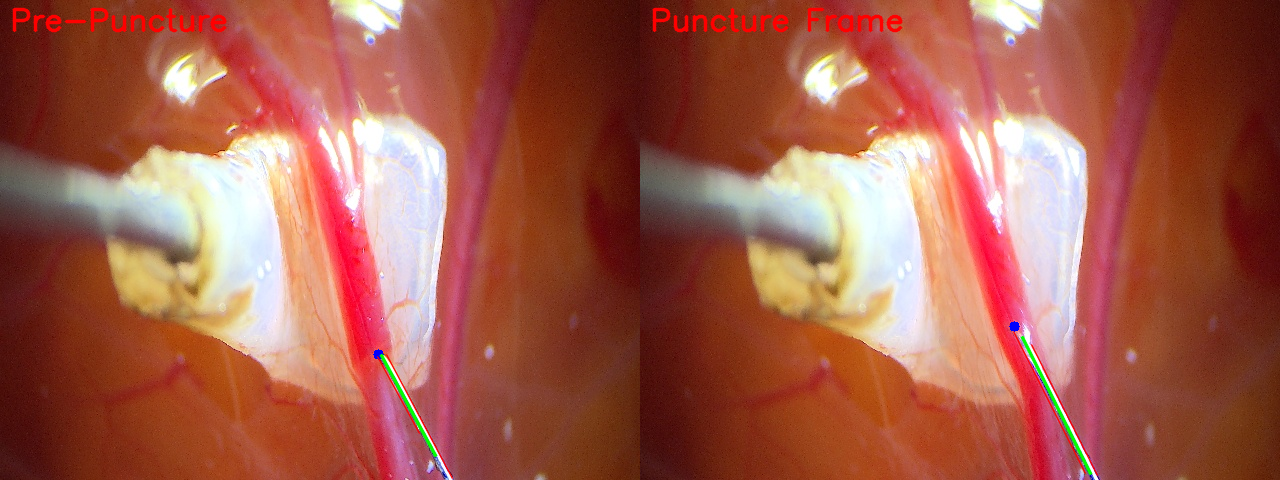

In [18]:
display(Image("puncture_frame_comparison.png", width=1))

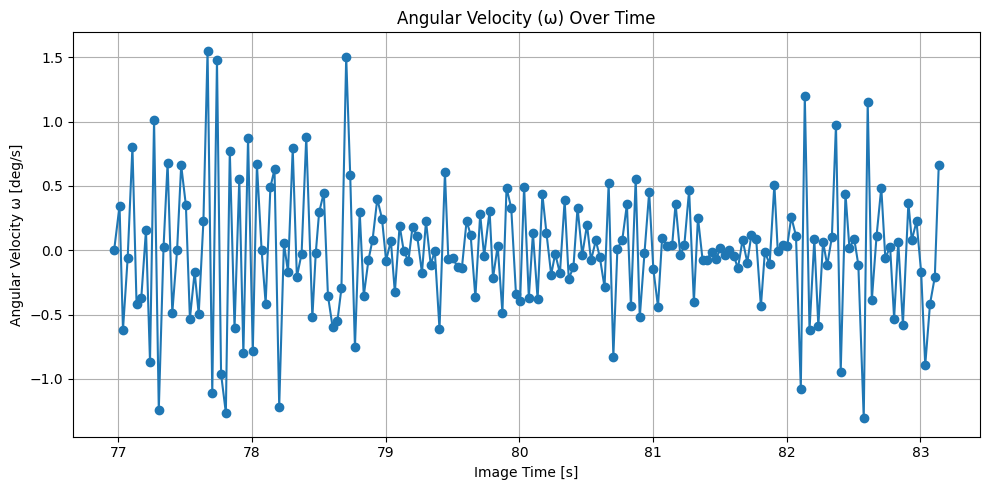

Successfully plotted


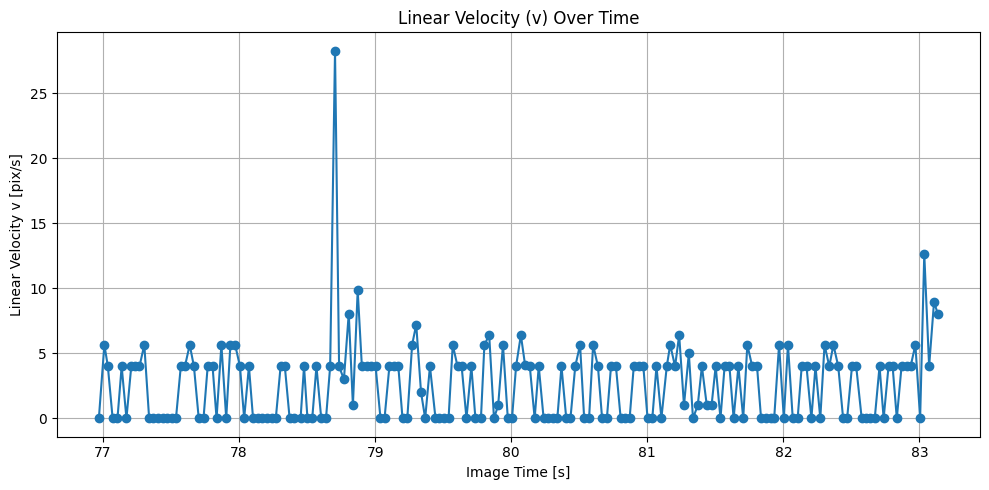

Successfully plotted


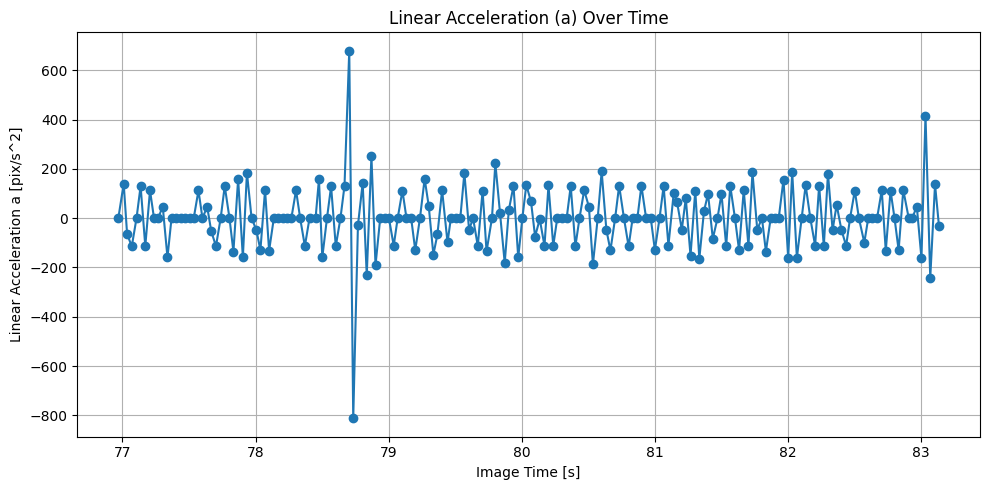

Successfully plotted


In [19]:
plot_w_over_time(csv_path)
plot_velocity_over_time(csv_path)
plot_acceleration_over_time(csv_path)

# Setup and Inference - UNET

In [20]:
import os
import csv
import cv2
import math
import numpy as np

# I need to make a new NeedleLogger for the UNET logging.
class NeedleLogger:
    def __init__(self, csv_path="needle_log.csv", overwrite=True):
        self.last_time = None
        self.last_angle = None
        self.last_tip = None
        self.last_image = None
        self.last_w = None
        self.last_v = None
        self.puncture_detected = False

        self.w_threshold = 30
        self.v_threshold = 17
        self.csv_path = csv_path

        self.frame_folder = os.path.join(os.path.dirname(self.csv_path), "video_frames")
        os.makedirs(self.frame_folder, exist_ok=True)
        self.frame_count = 0
        if overwrite and os.path.exists(self.csv_path):
            os.remove(self.csv_path)

        with open(self.csv_path, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                "image_time", "angle_deg", "inference_time_ms",
                "delta_t", "delta_angle", "w",
                "dx_dt", "dy_dt", "v", "alpha", "acceleration",
                "puncture_detected"
            ])

    def calculate(self, image_path, needle_data, inference_time_ms, tip_xy):
        image_filename = os.path.basename(image_path)
        image_time_str = image_filename.split("_")[-1].replace(".jpg", "")
        current_time = float(image_time_str)

        current_angle = needle_data["angle_deg"]
        dt = current_time - self.last_time if self.last_time is not None else 0.0
        dtheta = current_angle - self.last_angle if self.last_angle is not None else 0.0
        w = dtheta

        dx_dt = dy_dt = v = 0.0
        if self.last_tip is not None and dt > 0:
            dx = tip_xy[0] - self.last_tip[0]
            dy = tip_xy[1] - self.last_tip[1]
            dx_dt, dy_dt = dx, dy
            v = math.hypot(dx, dy)

        alpha = a = 0.0
        if self.last_w is not None and dt > 0:
            alpha = (w - self.last_w) / dt
        if self.last_v is not None and dt > 0:
            a = (v - self.last_v) / dt

        return {
            "image_time": image_time_str,
            "angle_deg": current_angle,
            "inference_time_ms": inference_time_ms,
            "delta_t": dt,
            "delta_angle": dtheta,
            "w": w,
            "dx_dt": dx_dt,
            "dy_dt": dy_dt,
            "v": v,
            "alpha": alpha,
            "acceleration": a,
            "puncture_detected": self.puncture_detected
        }

    def detect_puncture(self, log_data, current_image):
        if self.puncture_detected:
            return

        w = log_data["w"]
        v = log_data["v"]

        if v > self.v_threshold:
            print(f"Puncture detected at {log_data['image_time']}: w={w:.2f}, v={v:.2f}")
            self.puncture_detected = True

            pre_img = self.label_image(self.last_image, "Pre-Puncture") \
                      if self.last_image is not None else np.zeros_like(current_image)
            post_img = self.label_image(current_image, "Puncture Frame")
            combined = np.hstack((pre_img, post_img))
            cv2.imwrite("puncture_frame_comparison.png", combined)
            print("Puncture comparison saved to 'puncture_frame_comparison.png'")

        log_data["puncture_detected"] = self.puncture_detected

    def label_image(self, img, label):
        labeled = img.copy()
        cv2.putText(
            labeled, label, (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2, cv2.LINE_AA
        )
        return labeled

    def write_to_csv(self, log_data):
        with open(self.csv_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                log_data["image_time"], log_data["angle_deg"],
                log_data["inference_time_ms"], log_data["delta_t"],
                log_data["delta_angle"], log_data["w"],
                log_data["dx_dt"], log_data["dy_dt"], log_data["v"],
                log_data["alpha"], log_data["acceleration"],
                log_data["puncture_detected"]
            ])

    def update_last(self, log_data, tip_xy, current_image):
        self.last_time  = float(log_data["image_time"])
        self.last_angle = log_data["angle_deg"]
        self.last_w     = log_data["w"]
        self.last_v     = log_data["v"]
        self.last_tip   = tip_xy
        self.last_image = current_image.copy()

    def save_annotated_frame(
        self, image, tip, angle, w, v,
        timestamp_str, mask=None
    ):
        annotated = image.copy()

        if mask is not None:
            overlay = (mask.astype(np.uint8) * 255)
            overlay = cv2.resize(
                overlay,
                (image.shape[1], image.shape[0]),
                interpolation=cv2.INTER_NEAREST
            )
            annotated[overlay > 0] = (0, 0, 255)

        cv2.putText(
            annotated, f"Time: {timestamp_str}", (10, 25),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2
        )
        if self.puncture_detected:
            cv2.putText(
                annotated, "PUNCTURE DETECTED", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2
            )

        frame_path = os.path.join(
            self.frame_folder, f"frame_{self.frame_count:04d}.jpg"
        )
        cv2.imwrite(frame_path, annotated)
        self.frame_count += 1

    def compute(
        self,
        image_path,
        needle_data,
        inference_time_ms,
        tip_xy,
        current_image,
        mask=None,
        csv_path=None
    ):
        # optionally override csv_path per-call
        if csv_path is not None:
            self.csv_path = csv_path

        log_data = self.calculate(
            image_path, needle_data, inference_time_ms, tip_xy
        )
        self.detect_puncture(log_data, current_image)
        self.write_to_csv(log_data)
        self.update_last(log_data, tip_xy, current_image)
        self.save_annotated_frame(
            current_image, tip_xy,
            log_data["angle_deg"], log_data["w"],
            log_data["v"], log_data["image_time"],
            mask=mask
        )
        return log_data

    def finalize_video(self, output_path="needle_tracking.mp4", fps=10):
        images = sorted(
            img for img in os.listdir(self.frame_folder)
            if img.lower().endswith((".jpg", ".png"))
        )
        if not images:
            print("No frames to compile.")
            return

        first_frame = cv2.imread(os.path.join(self.frame_folder, images[0]))
        h, w = first_frame.shape[:2]
        writer = cv2.VideoWriter(
            output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h)
        )
        for img_name in images:
            frame = cv2.imread(os.path.join(self.frame_folder, img_name))
            writer.write(frame)
        writer.release()

        # clean up
        for img_name in images:
            os.remove(os.path.join(self.frame_folder, img_name))

        print(f" Video created at: {output_path}")

In [22]:
from google.colab.patches import cv2_imshow

inference_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])

def run_inference_unet(image_path, thresh=0.5, verbose=False):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"cv2.imread failed for {image_path}")
    h_orig, w_orig = img.shape[:2]

    # Preprocess exactly as in training
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    inp = inference_transform(img_rgb).unsqueeze(0).to(device)  # [1,3,256,256]

    # Inference
    model.eval()
    start_ts = time.time()
    with torch.no_grad():
        out = model(inp)                        # [1,1,256,256]
    inference_time_ms = (time.time() - start_ts) * 1000

    # Binary mask & resize back
    prob = torch.sigmoid(out)[0,0].cpu().numpy()
    mask256 = (prob >= thresh).astype(np.uint8)
    mask_full = cv2.resize(mask256, (w_orig, h_orig),
                           interpolation=cv2.INTER_NEAREST)

    # # Visualization
    # plt.figure(figsize=(12,5))
    # # original
    # plt.subplot(1,2,1)
    # plt.imshow(img_rgb)
    # plt.title("Input Image")
    # plt.axis("off")
    # # mask
    # plt.subplot(1,2,2)
    # plt.imshow(mask_full, cmap="gray", vmin=0, vmax=1)
    # plt.title(f"Predicted Mask (thresh={thresh})")
    # plt.axis("off")
    # plt.show()

    # Continue your existing edge/contour pipeline
    edge_lines, needle_tip = detect_needle_and_edges(mask_full, img)
    needle = calc_needle_params(edge_lines, img)
    if needle is not None:
        log_data = logger.compute(image_path, needle, inference_time_ms, needle_tip, img, mask=mask_full)
        return log_data
    else:
        if verbose:
            print("No needle detected.")
        return None


In [23]:
# PROJECT_ROOT = r'C:\Users\Aabha\OneDrive - Johns Hopkins\_Classes\S25\MLMA (520.659)\MLMA Final Project'
PROJECT_ROOT = r'/content'

# starting_image_path = os.path.join(PROJECT_ROOT, "Data", "Egg02_01_TP", "iOCT_image_857.0341280000.jpg")
starting_image_path = os.path.join(PROJECT_ROOT, "Data", "Egg02_04_FN", "iOCT_image_76.9686740000.jpg")
# starting_image_path = os.path.join(PROJECT_ROOT, "Data", "Egg14_01_FN", "iOCT_image_630.2711000000.jpg")
# starting_image_path = os.path.join(PROJECT_ROOT, "Data", "Egg06_05_TP", "iOCT_image_40.6636490000.jpg")
# # THIS WAS IN TRAINING
# starting_image_path = os.path.join(PROJECT_ROOT, "Data", "Egg03_03_FP", "iOCT_image_267.1962610000.jpg")
# starting_image_path = os.path.join(PROJECT_ROOT, "Data", "Egg05_01_TP", "iOCT_image_107.9209350000.jpg")
image_dir_name = os.path.basename(os.path.dirname(starting_image_path))
results_folder = os.path.join(PROJECT_ROOT, "MLMAFinalProjectCode", "Results","04.27", "UNET")
csv_path = os.path.join(results_folder, f"{image_dir_name}_needle_log.csv")
video_path = os.path.join(results_folder, f"{image_dir_name}_needle_tracking.mp4")
num_images = 200
image_paths = get_image_paths(starting_image_path, num_images)

class_map = {0: "Needle", 1: "Vein"
}

os.makedirs(results_folder, exist_ok=True)
logger = NeedleLogger(csv_path=csv_path)

In [24]:
model_path = os.path.join(PROJECT_ROOT, "MLMAFinalProjectCode", "Models", "unet_best_model.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(encoder_name="mobilenet_v2", encoder_weights="imagenet",in_channels=3, classes=1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [25]:
# Total parameters (all layers)
total_params = sum(p.numel() for p in model.parameters())

# Trainable parameters only
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total params:     {total_params:,}")
print(f"Trainable params: {trainable_params:,}")

Total params:     6,628,945
Trainable params: 6,628,945


In [26]:
# Running Inference
for path in image_paths:
    run_inference_unet(path, thresh=0.362, verbose=False)

if not logger.puncture_detected:
    print("No puncture detected in this sequence")

Puncture detected at 78.7044990000: w=0.56, v=23.19
Puncture comparison saved to 'puncture_frame_comparison.png'


In [27]:
logger.finalize_video(video_path)

 Video created at: /content/MLMAFinalProjectCode/Results/04.27/UNET/Egg02_04_FN_needle_tracking.mp4


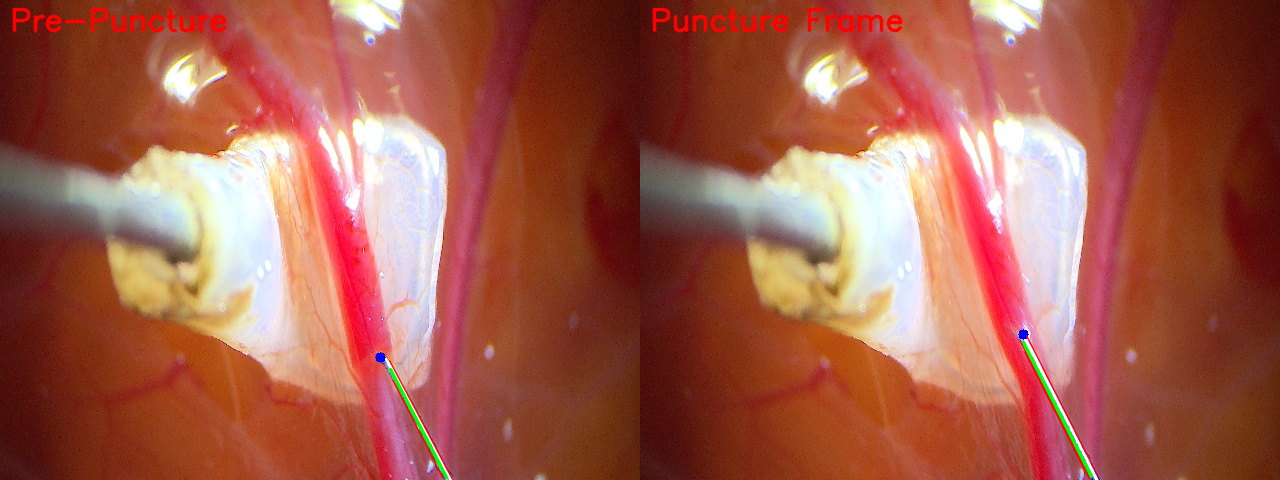

In [28]:
display(Image("puncture_frame_comparison.png", width=1))

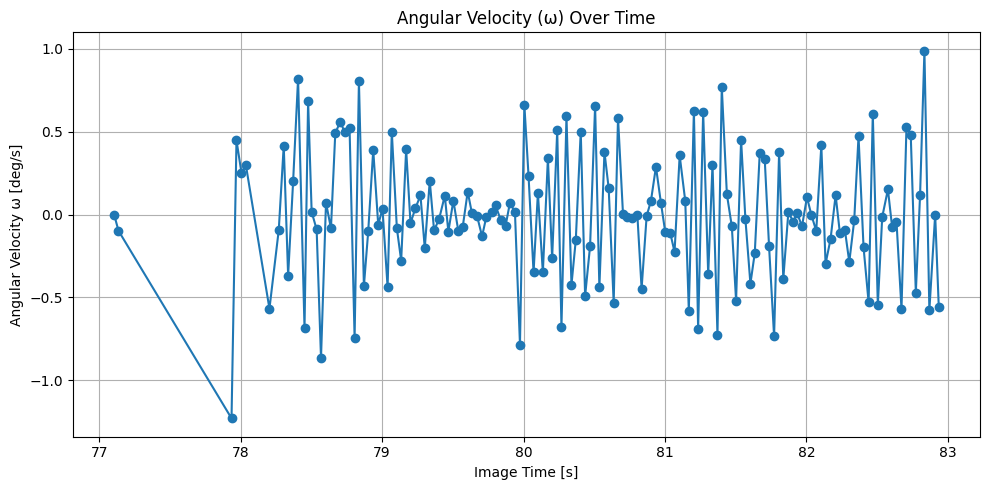

Successfully plotted


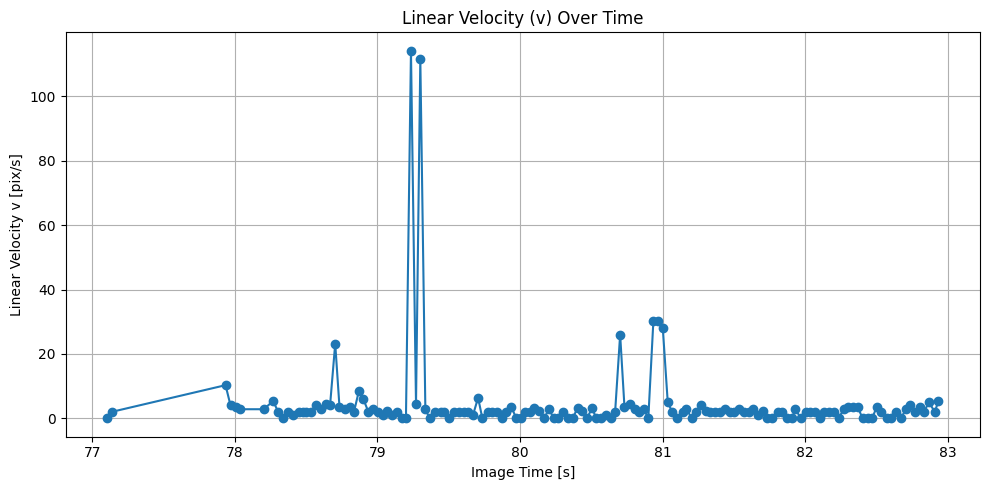

Successfully plotted


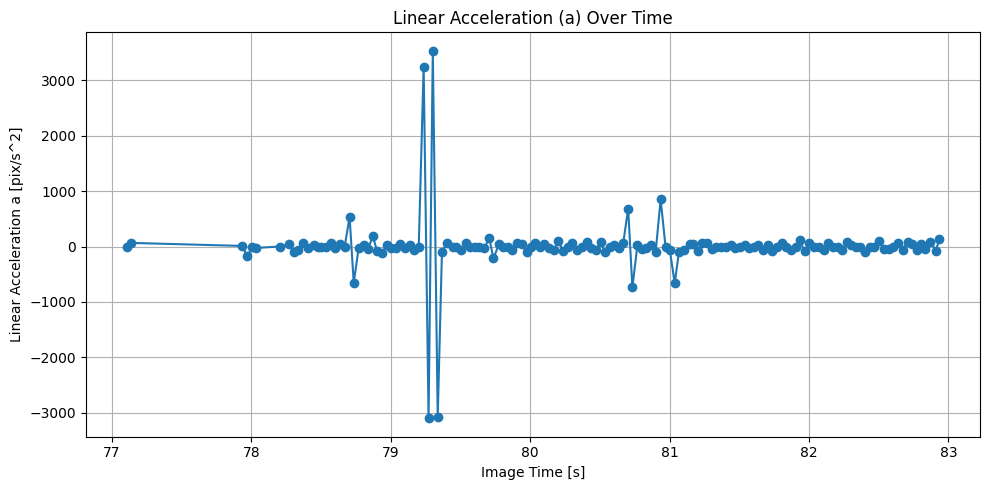

Successfully plotted


In [29]:
plot_w_over_time(csv_path)
plot_velocity_over_time(csv_path)
plot_acceleration_over_time(csv_path)